In [26]:
# 导入库
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import Legendre
from scipy.special import legendre # legendre(n)用于生成n阶勒让德多项式。
# 勒让德多项式是一类正交多项式，常用于数值分析、物理问题的求解以及函数逼近。
from scipy.integrate import fixed_quad 
#fixed_quad是一种使用固定阶数的高斯求积法进行数值积分的函数。
#它对于积分光滑函数非常精确和高效。
from scipy.linalg import eig
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
# eig：用于计算一般方阵的特征值和特征向量。
# eigh：用于计算厄米特（Hermitian）矩阵或实对称矩阵的特征值和特征向量。
# eigsh：用于计算大型稀疏对称矩阵的特征值。
import warnings

In [27]:
def generate_data(M, method_type):
    """
    生成数据点X和权重W
    Parameters:
    M: 样本数量
    method_type: 0=蒙特卡洛, 1=高斯-勒让德, 2=梯形法则, 其他=黎曼和
    Returns:
    X: 数据点
    W: 权重
    DATA: 演化后的数据
    """
    alpha = 2
    beta = -1 - np.exp(-alpha)
    
    if method_type == 1:
        # 高斯-勒让德求积
        X, W = np.polynomial.legendre.leggauss(M)
        X = (X + 1) / 2 - 1  # 从[-1,1]缩放到[-1,0]
        W = W / 2
    elif method_type == 2:
        # 梯形法则
        X = np.linspace(-1, 0, M)
        W = np.ones(M) * (X[1] - X[0])
        W[0] = W[0] / 2
        W[-1] = W[-1] / 2
    elif method_type == 0:
        # 蒙特卡洛
        X = -np.random.rand(M)
        W = np.ones(M) / M
    else:
        # 黎曼和
        X = np.linspace(-1, 0, M)
        W = np.ones(M) * (X[1] - X[0])
    
    DATA = np.exp(-alpha * X**2) + beta
    
    return X, W, DATA

In [28]:
def compute_basis_functions(X, DATA, N):
    """
    计算基函数矩阵
    
    Parameters:
    X: 数据点
    DATA: 演化后的数据
    N: 基函数数量
    
    Returns:
    XH: 初始状态基函数矩阵
    YH: 演化后状态基函数矩阵
    """
    M = len(X)
    XH = np.zeros((M, N))
    YH = np.zeros((M, N))
    
    for j in range(N):
        poly_coeffs = np.zeros(j + 1)
        poly_coeffs[-1] = 1
        XH[:, j] = np.polynomial.legendre.legval(2 * X + 1, poly_coeffs) * np.sqrt(2 / (2 * j + 1)) * np.sqrt(2)
        YH[:, j] = np.polynomial.legendre.legval(2 * DATA + 1, poly_coeffs) * np.sqrt(2 / (2 * j + 1)) * np.sqrt(2)
    
    return XH, YH

In [29]:
def compute_koopman_matrices(XH,W,YH):
    """
    构造三个ResDMD矩阵
    
    Parameters:
    MXH+YH
    
    Returns:
    G: Gram矩阵<psi_j, psi_i>
    A: 第一个Galerkin矩阵 <K psi_j, psi_i>
    L: 第二个Galerkin矩阵 <K psi_j, K psi_i>
    """
    M = XH.shape[0]
    N = XH.shape[1]
    # 初始化矩阵
    G = np.zeros((N, N))
    A = np.zeros((N, N))
    L = np.zeros((N, N))
    
    # 计算矩阵元素
    for j in range(M):
        G += np.outer(XH[j, :] * W[j], XH[j, :])
        A += np.outer(XH[j, :] * W[j], YH[j, :])
        L += np.outer(YH[j, :] * W[j], YH[j, :])
    
    return G, A, L

In [30]:
def compute_edmd_eigenpairs(G, A, L):
    """
    根据算法2步骤2，求解广义特征值问题 A g = λ G g
    返回特征值和对应的特征向量（系数向量）

    Parameters:
    G: Gram矩阵 Ψ_X^* W Ψ_X
    A: 矩阵 Ψ_X^* W Ψ_Y
    L: 矩阵 Ψ_Y^* W Ψ_Y

    Returns:
    eigenvalues: 特征值数组
    eigenvectors: 特征向量矩阵，每一列是一个特征向量 g
    """
    eigenvalues, eigenvectors = eig(A, G)
    return eigenvalues, eigenvectors

In [31]:
def compute_residual(lambda_val, g, G, A, L):
    """
    根据公式(4.6)计算给定特征对(λ, g)的残差

    Parameters:
    lambda_val: 特征值 λ
    g: 特征向量（系数向量）
    G, A, L: ResDMD矩阵

    Returns:
    res: 残差值
    """
    g = g.reshape(-1, 1) # 确保是列向量
    gH = g.T.conj() # 行向量，g的共轭转置

    # 计算分子: g^* (L - λ A^H - \bar{λ} A + |λ|^2 G) g
    numerator_matrix = L - lambda_val * A.T.conj() - np.conj(lambda_val) * A + (np.abs(lambda_val)**2) * G
    numerator = (gH @ numerator_matrix @ g).item()
    numerator = np.real(numerator) # 确保是实数

    # 计算分母: g^* G g
    denominator = (gH @ G @ g).item()
    denominator = np.real(denominator)

    # 避免除零，计算残差
    if denominator <= 0:
        return np.inf
    else:
        res_squared = numerator / denominator
        # 由于数值误差，结果可能为负，取绝对值再开方
        return np.sqrt(np.abs(res_squared))

In [32]:
def koop_pseudo_spec(G, A, L, z_pts, **kwargs):
    """
    计算K的伪谱
    
    Parameters:
    G: Gram矩阵<psi_j, psi_i>
    A: 第一个Galerkin矩阵 <K psi_j, psi_i>
    L: 第二个Galerkin矩阵 <K psi_j, K psi_i>
    z_pts: 复数点向量，用于计算伪谱
    
    Optional:
    reg_param: G的正则化参数
    
    Returns:
    RES: z_pts处的残差
    """
    # 解析可选参数
    reg_param = kwargs.get('reg_param', 1e-14)
    
    # 确保矩阵是Hermitian的
    G = (G + G.T.conj()) / 2
    L = (L + L.T.conj()) / 2
    
    # 正则化G并计算SQ矩阵
    G_reg = G + np.linalg.norm(G) * reg_param * np.eye(G.shape[0])
    w, V = eigh(G_reg)
    
    # 避免除零和负值
    w = np.maximum(w, 1e-15)
    w_sqrt = np.sqrt(1.0 / np.abs(w))
    SQ = V @ np.diag(w_sqrt) @ V.T.conj()
    
    z_pts = z_pts.flatten()
    LL = len(z_pts)
    RES = np.zeros(LL, dtype=float)
    
    if LL > 0:
        warnings.filterwarnings('ignore', category=UserWarning)
        
        for jj in range(LL):
            z = z_pts[jj]
            try:
                # 构造该z对应的矩阵
                M_z = (L - z * A.T.conj() - np.conj(z) * A + (np.abs(z)**2) * G)
                M_transformed = SQ @ M_z @ SQ
                
                # 确保矩阵是Hermitian的以用于eigvalsh
                M_transformed = (M_transformed + M_transformed.T.conj()) / 2
                
                # 使用稠密计算找到最小特征值（更稳定）
                eigvals = np.linalg.eigvalsh(M_transformed)
                min_eigval = np.min(np.real(eigvals))
                
                # 避免由于数值误差导致的负值
                RES[jj] = np.sqrt(max(0, min_eigval))
                
            except Exception as e:
                print(f"Warning: Error at z={z}: {e}")
                RES[jj] = np.nan
    
    warnings.resetwarnings()
    
    return RES

In [33]:
def plot_pseudospectra(G, A, L, step=0.05, residual_threshold=0.01, padding_ratio=0.2, fixed_range=None):
    """
    绘制伪谱图，并根据残差阈值区分可靠和虚假特征值

    Parameters:
    G, A, L: Koopman矩阵
    x_range, y_range: 绘图范围
    step: 网格步长
    residual_threshold: 算法2中的残差阈值ε
    padding_ratio: 在特征值范围基础上添加的边距比例
    fixed_range: 如果提供，则使用固定的绘图范围 (x_min, x_max, y_min, y_max)
    """
    # 1. 计算EDMD特征对 (算法2步骤2)
    eigenvalues, eigenvectors = compute_edmd_eigenpairs(G, A, L)
    # 特征向量在矩阵eigenvectors的列中

    # 2. 为每个特征对计算残差 (算法2步骤3的逻辑)
    residuals = []
    reliable_indices = []
    spurious_indices = []

    for i in range(len(eigenvalues)):
        lambda_i = eigenvalues[i]
        g_i = eigenvectors[:, i]
        res_i = compute_residual(lambda_i, g_i, G, A, L)
        residuals.append(res_i)

        if res_i <= residual_threshold:
            reliable_indices.append(i)
        else:
            spurious_indices.append(i)

    print(f"总特征值数量: {len(eigenvalues)}")
    print(f"可靠特征值数量 (res <= {residual_threshold}): {len(reliable_indices),reliable_indices}")
    print(f"虚假特征值数量 (res > {residual_threshold}): {len(spurious_indices)}")

    # 3. 确定绘图范围
    if fixed_range is not None:
        # 使用固定的绘图范围
        x_range = (fixed_range[0], fixed_range[1])
        y_range = (fixed_range[2], fixed_range[3])
    else:
        # 自适应范围：基于所有特征值的分布
        real_parts = np.real(eigenvalues)
        imag_parts = np.imag(eigenvalues)
        
        # 计算特征值的范围
        real_min, real_max = np.min(real_parts), np.max(real_parts)
        imag_min, imag_max = np.min(imag_parts), np.max(imag_parts)
        
        # 使用相同的范围，保持纵横比一致
        overall_min = min(real_min, imag_min)
        overall_max = max(real_max, imag_max)
        overall_range = overall_max - overall_min
        
        # 如果范围太小（如所有特征值都集中在一点），设置最小范围
        if overall_range < 0.1:
            overall_range = 1.0
            center = (overall_min + overall_max) / 2
            overall_min = center - 0.5
            overall_max = center + 0.5
        
        # 添加边距
        padding = overall_range * padding_ratio
        x_range = (overall_min - padding, overall_max + padding)
        y_range = (overall_min - padding, overall_max + padding)
    
    # 3. 计算伪谱网格（算法3/原有伪谱计算逻辑）
    x_pts = np.arange(x_range[0], x_range[1] + step, step)
    y_pts = np.arange(y_range[0], y_range[1] + step, step)
    X_grid, Y_grid = np.meshgrid(x_pts, y_pts)
    z_pts = X_grid + 1j * Y_grid
    z_flat = z_pts.flatten()

    RES = koop_pseudo_spec(G, A, L, z_flat)
    RES = RES.reshape(z_pts.shape)
    RES = np.nan_to_num(RES, nan=np.max(RES[~np.isnan(RES)]))

    # 4. 绘图
    plt.figure(figsize=(8, 8))

    # 伪谱等高线
    levels = [0.001, 0.01, 0.1, 0.3]
    contour = plt.contour(X_grid, Y_grid, np.real(RES), levels=levels,
                         colors='black', linewidths=2)
    plt.clabel(contour, inline=True, fontsize=11, fmt='%.3f')

    # 绘制特征值
    # 可靠特征值 (残差小) - 蓝色十字
    reliable_eigs = eigenvalues[reliable_indices]
    plt.plot(np.real(reliable_eigs), np.imag(reliable_eigs), 'x',
             markersize=8, color='blue', markeredgewidth=2,
             label=f'Reliable eigenvalues (res $\leq$ {residual_threshold})')

    # 虚假特征值 (残差大) - 洋红点
    spurious_eigs = eigenvalues[spurious_indices]
    plt.plot(np.real(spurious_eigs), np.imag(spurious_eigs), '.',
             markersize=10, color='magenta',
             label='Spurious eigenvalues')

    # 格式化
    plt.gca().set_aspect('equal')
    plt.xlabel('Real', fontsize=14)
    plt.ylabel('Imaginary', fontsize=14)
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)
    plt.title(f'Pseudospectrum and Eigenvalues (Residual Threshold = {residual_threshold})', fontsize=14)
    plt.tight_layout()
    plt.show()
    return eigenvalues, residuals, reliable_indices

<>:93: DeprecationWarning: invalid escape sequence '\l'
<>:93: DeprecationWarning: invalid escape sequence '\l'
C:\Users\Administrator.DESKTOP-BFUOLPM\AppData\Local\Temp\ipykernel_25900\3006186818.py:93: DeprecationWarning: invalid escape sequence '\l'
  label=f'Reliable eigenvalues (res $\leq$ {residual_threshold})')


In [41]:
def plot_quadrature_errors(methods,colors):
    """绘制求积误差图 - 修复参考线和主曲线问题"""
    # 计算参考解
    X, W, DATA = generate_data(M=200, method_type=1)
    XH, YH = compute_basis_functions(X, DATA, N=40)
    _, test_ref, _ = compute_koopman_matrices(XH,W,YH)
    
    # 样本大小向量 - 确保唯一性
    Mvec = np.unique(np.round(10**(np.arange(0.2, 4.05, 0.05))).astype(int))
    Mvec = Mvec[Mvec != 200]  # 移除200如果存在
    Mvec = np.append(Mvec, 201)  # 添加201
    Mvec = np.sort(Mvec)  # 确保排序
    
    me = len(methods)
    E = np.zeros((len(Mvec), me))
    
    for ct, j in enumerate(Mvec):
        for k in range(me):
            #A_mat = compute_koopman_matrices(j, k)[1]
            XX, WW, DATAD = generate_data(M=j, method_type=k)
            XHH, YHH = compute_basis_functions(XX, DATAD, N=40)
            A_mat = compute_koopman_matrices(XHH,WW,YHH)[1]
            E[ct, k] = np.max(np.abs(test_ref - A_mat))
    
    # 绘制结果
    plt.figure(figsize=(8, 6))
    
    # 主曲线 - 确保每条线只绘制一次
    #methods = ['Monte Carlo', 'Gauss--Legendre', 'Trapezoidal', 'Riemann sum']
    #colors = ['purple', 'blue', 'red', 'orange']
    
    for k in range(me):
        # 过滤掉NaN值
        valid_mask = ~np.isnan(E[:, k]) & (E[:, k] > 0)
        if np.any(valid_mask):
            plt.loglog(Mvec[valid_mask], E[valid_mask, k], linewidth=2, 
                      label=methods[k], color=colors[k])
    
    # 参考线
    mask = Mvec >= 20  # 扩大范围
    
    # 调整比例常数以避免重叠
    plt.loglog(Mvec[mask], 10 / Mvec[mask], 'k:', linewidth=2, 
               alpha=0.7, label=r'$O(1/M)$')
    plt.loglog(Mvec[mask], 200 / Mvec[mask]**2, 'k--', linewidth=2, 
               alpha=0.7, label=r'$O(1/M^2)$')
    plt.loglog(Mvec[mask], 5 / np.sqrt(Mvec[mask]), 'k-.', linewidth=2, 
               alpha=0.7, label=r'$O(1/\sqrt{M})$')
    
    # 格式化
    plt.legend(fontsize=12, loc='lower right', framealpha=0.7)
    plt.xlabel('Sample size M', fontsize=14)
    plt.ylabel('Max Error', fontsize=14)
    plt.xlim(1, 10000)
    plt.ylim(1e-15, 10)
    plt.grid(True, alpha=0.3, which='both')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('Quadrature Errors Convergence', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return E

总特征值数量: 40
可靠特征值数量 (res <= 0.01): (16, [0, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
虚假特征值数量 (res > 0.01): 24


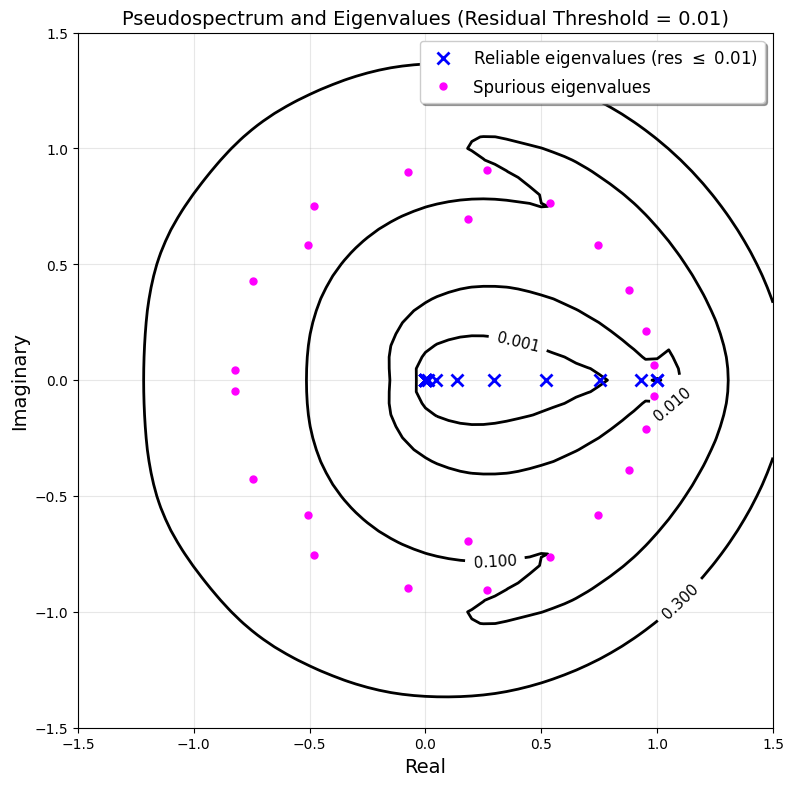

(array([ 1.00000000e+00+0.j        , -8.23833594e-01+0.04548677j,
        -8.23833594e-01-0.04548677j, -7.43367724e-01+0.42593341j,
        -7.43367724e-01-0.42593341j, -4.83003500e-01+0.75270677j,
        -4.83003500e-01-0.75270677j, -5.06926498e-01+0.58351173j,
        -5.06926498e-01-0.58351173j, -7.65665623e-02+0.89783274j,
        -7.65665623e-02-0.89783274j,  2.65009168e-01+0.9051076j ,
         2.65009168e-01-0.9051076j ,  1.81727350e-01+0.69564039j,
         1.81727350e-01-0.69564039j,  5.37323716e-01+0.76330488j,
         5.37323716e-01-0.76330488j,  7.44522261e-01+0.58141439j,
         7.44522261e-01-0.58141439j,  8.76360884e-01+0.38870061j,
         8.76360884e-01-0.38870061j,  9.50225003e-01+0.21019322j,
         9.50225003e-01-0.21019322j,  9.86386154e-01+0.06756002j,
         9.86386154e-01-0.06756002j,  1.00015623e+00+0.j        ,
         9.30463710e-01+0.j        ,  7.54560496e-01+0.j        ,
         5.20986130e-01+0.j        ,  2.97606505e-01+0.j        ,
         1

In [36]:
# 计算Koopman矩阵（例如，使用Gauss-Legendre方法）
# 生成数据
X, W, DATA = generate_data(M=100, method_type=1)
    
# 计算基函数
XH, YH = compute_basis_functions(X, DATA, N=40)
    
G, A, L = compute_koopman_matrices(XH,W,YH)
# 绘制伪谱图，并区分可靠/虚假特征值
plot_pseudospectra(G, A, L, residual_threshold=0.01,fixed_range=(-1.5,1.5,-1.5,1.5))

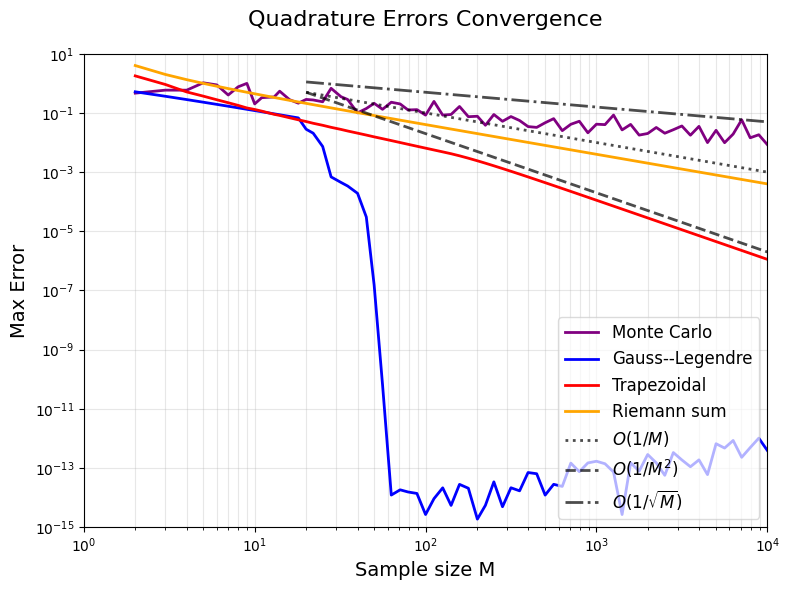

array([[4.67027552e-01, 5.18518519e-01, 1.78885438e+00, 4.00000000e+00],
       [5.89940229e-01, 3.66102130e-01, 9.16666667e-01, 2.00000000e+00],
       [5.88830694e-01, 2.83123219e-01, 5.12850387e-01, 1.33333333e+00],
       [1.04378050e+00, 2.30863422e-01, 3.69980697e-01, 1.00000000e+00],
       [8.87315739e-01, 1.94910140e-01, 2.79218362e-01, 8.00000000e-01],
       [4.03840188e-01, 1.68655028e-01, 2.21374275e-01, 6.66666667e-01],
       [7.63725615e-01, 1.48637902e-01, 1.80005595e-01, 5.71428571e-01],
       [9.97975819e-01, 1.32870549e-01, 1.47518685e-01, 5.00000000e-01],
       [2.02088956e-01, 1.20128900e-01, 1.30938757e-01, 4.44444444e-01],
       [3.28872557e-01, 1.09617968e-01, 1.15172132e-01, 4.00000000e-01],
       [3.47157145e-01, 9.32935981e-02, 8.98945394e-02, 3.33333333e-01],
       [5.44436740e-01, 8.68287248e-02, 8.24727084e-02, 3.07692308e-01],
       [2.80780404e-01, 7.62601504e-02, 6.87099958e-02, 2.66666667e-01],
       [2.14076692e-01, 6.79854854e-02, 5.86085918e

In [42]:
methods = ['Monte Carlo', 'Gauss--Legendre', 'Trapezoidal', 'Riemann sum']
colors = ['purple', 'blue', 'red', 'orange']
plot_quadrature_errors(methods,colors)